In [1]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve
from sentence_transformers import SentenceTransformer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = TFAutoModel.from_pretrained("bert-base-uncased")
# Alternatively, use SentenceTransformer for easier sentence embeddings
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification mode

In [22]:
def get_contextual_embeddings(texts, use_sentence_transformer=True):

    if not isinstance(texts, list):
        texts = [texts]
    if use_sentence_transformer:
        return sentence_model.encode(texts)
    else:
        inputs = tokenizer(texts, return_tensors="tf", padding=True, truncation=True, max_length=128)
        outputs = model(inputs)
        # Use the [CLS] token embedding as the sentence representation
        return outputs.last_hidden_state[:, 0, :].numpy()

def contextual_similarity(emb1, emb2):
    return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))

def get_batch_embeddings(texts, batch_size=512):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        batch_embeddings = get_contextual_embeddings(batch)
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

def find_optimal_threshold(similarities, ground_truth, keyword):
    y_true = [1 if item in ground_truth[keyword] else 0 for item in corpus]
    precision, recall, thresholds = precision_recall_curve(y_true, similarities)
    
    # Calculate F1 score
    epsilon = 1e-10
    f1_scores = 2 * (precision * recall) / (precision + recall + epsilon)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    # Plot precision-recall curve
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red', label=f'Optimal threshold: {optimal_threshold:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for "{keyword}"')
    plt.legend()
    plt.show()
    
    return optimal_threshold

def get_similar_keyword_suggestions(keyword_list, corpus, ground_truth, batch_size=512, max_suggestions=25):
    keyword_embeddings = get_contextual_embeddings(keyword_list)
    corpus_embeddings = get_batch_embeddings(corpus, batch_size)
    
    suggestions = {}
    for i, keyword in enumerate(keyword_list):
        similarities = np.dot(corpus_embeddings, keyword_embeddings[i]) / (np.linalg.norm(corpus_embeddings, axis=1) * np.linalg.norm(keyword_embeddings[i]))
        
        # Find optimal threshold
        optimal_threshold = find_optimal_threshold(similarities, ground_truth, keyword)
        
        # Filter similarities based on optimal threshold
        valid_indices = np.where(similarities >= optimal_threshold)[0]
        
        # Sort the valid indices by similarity
        sorted_indices = valid_indices[np.argsort(similarities[valid_indices])[::-1]]
        
        # Get the top suggestions (up to max_suggestions)
        top_indices = sorted_indices[:max_suggestions]
        
        suggestions[keyword] = [
            (corpus[idx], similarities[idx])  # Include similarity score in output
            for idx in top_indices
        ]
    
    return suggestions



In [23]:
import pandas as pd
df = pd.read_csv('FinalGoogleKeywords.csv')

In [24]:
# Example usage
keyword_list = ["cardigan", "denim shirt", "jeans", "necklace"]
corpus = df['Keywords'].tolist()
# corpus = ["chenille sweater", "cashmere sweater", "tommy sweatshirt", "spring coat", "moncler jacket mens",
#           "under armour sweatshirt", "levis denim jacket", "tommy jeans t shirt", "denim outfit",
#           "skinny trousers", "pleather pants", "best flare jeans", "adidas briefs", "nike mesh shorts",
#           "jewellery for saree", "mens personalised bracelet", "silver nose ring", "sapphire earrings studs"]

ground_truth = {
    "cardigan": ["chenille sweater", "cashmere sweater", "tommy sweatshirt", "spring coat", "moncler jacket mens"],
    "denim shirt": ["under armour sweatshirt", "levis denim jacket", "tommy jeans t shirt", "denim outfit"],
    "jeans": ["skinny trousers", "pleather pants", "best flare jeans", "adidas briefs", "nike mesh shorts"],
    "necklace": ["jewellery for saree", "mens personalised bracelet", "silver nose ring", "sapphire earrings studs"]
}

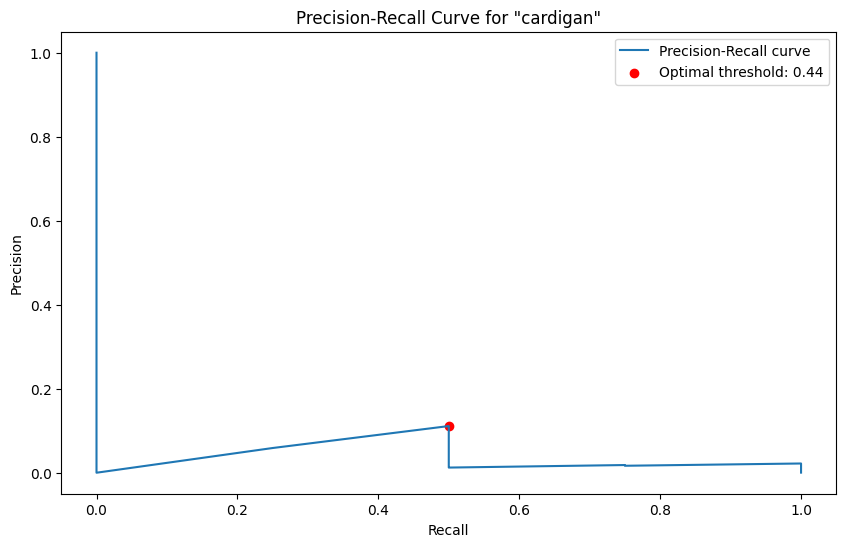

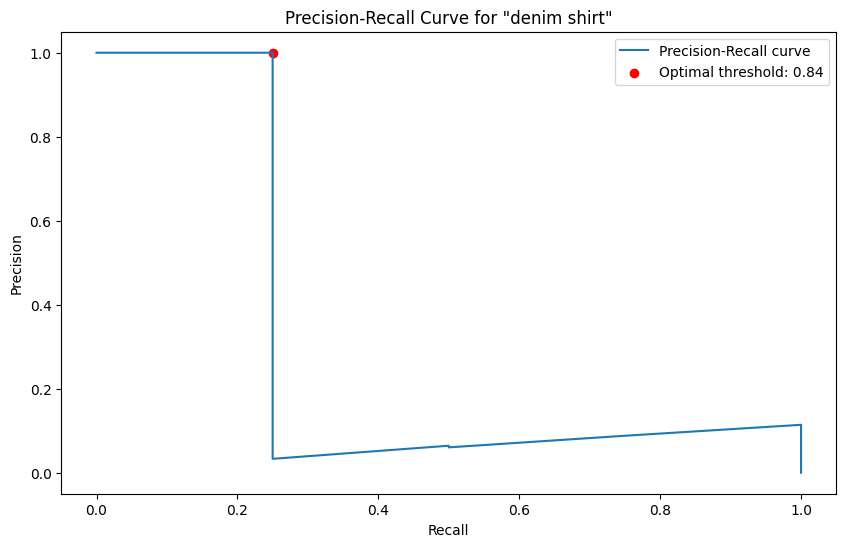

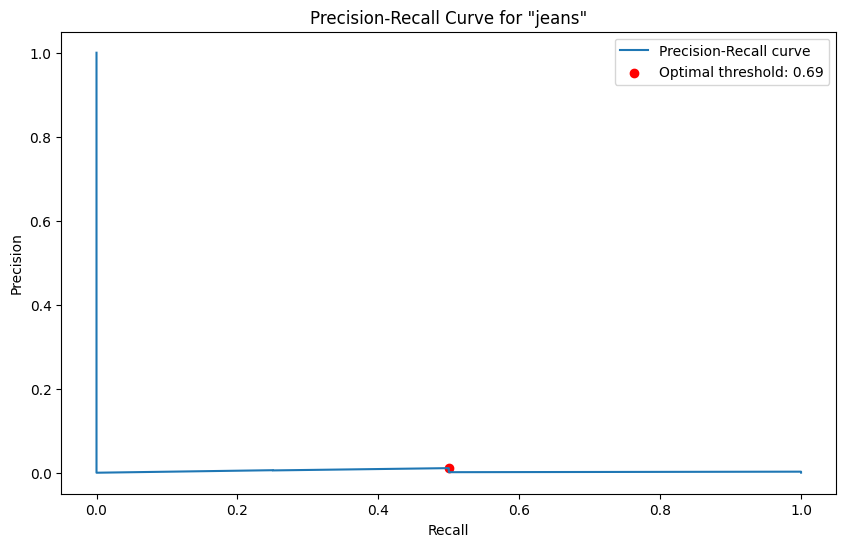

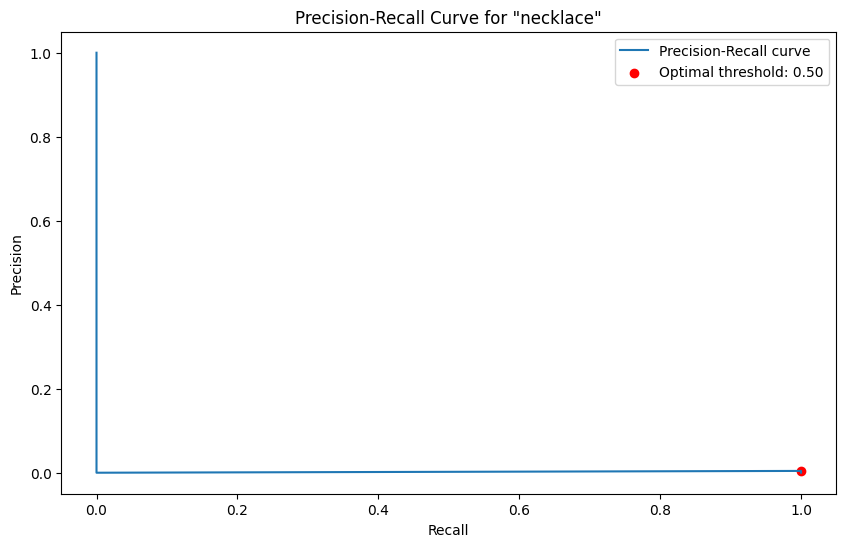

Suggestions for 'cardigan':
  - shein cardigan (similarity: 0.8534)
  - ladies cardigans (similarity: 0.8022)
  - moncler cardigan (similarity: 0.7932)
  - cardigan jacket (similarity: 0.7845)
  - long black cardigan (similarity: 0.7833)

Suggestions for 'denim shirt':
  - denim outfit (similarity: 0.8378)

Suggestions for 'jeans':
  - jeans denim (similarity: 0.9174)
  - white jeans (similarity: 0.8925)
  - tight jeans (similarity: 0.8914)
  - colored jeans (similarity: 0.8877)
  - pink jeans (similarity: 0.8731)

Suggestions for 'necklace':
  - necklace (similarity: 1.0000)
  - necklace design (similarity: 0.8745)
  - amber necklace (similarity: 0.8529)
  - bib necklace (similarity: 0.8516)
  - personalised necklace (similarity: 0.8427)



In [25]:
suggestions = get_similar_keyword_suggestions(keyword_list, corpus, ground_truth, max_suggestions=5)

# Print results
for keyword, similar_words in suggestions.items():
    print(f"Suggestions for '{keyword}':")
    for word, similarity in similar_words:
        print(f"  - {word} (similarity: {similarity:.4f})")
    print()

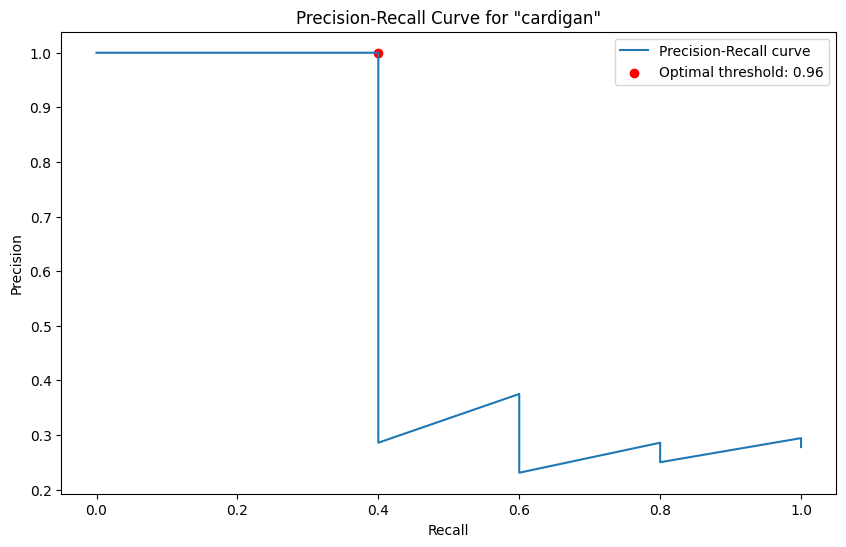

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def find_optimal_threshold(similarities, ground_truth, keyword, corpus):
    y_true = [1 if item in ground_truth[keyword] else 0 for item in corpus]
    precision, recall, thresholds = precision_recall_curve(y_true, similarities)
    
    # Calculate F1 score
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Add small epsilon to avoid division by zero
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    # Plot precision-recall curve
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red', label=f'Optimal threshold: {optimal_threshold:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for "{keyword}"')
    plt.legend()
    plt.show()
    
    return optimal_threshold

# Example usage
keyword_list = ["cardigan", "denim shirt", "jeans", "necklace"]
corpus = ["chenille sweater", "cashmere sweater", "tommy sweatshirt", "spring coat", "moncler jacket mens",
          "under armour sweatshirt", "levis denim jacket", "tommy jeans t shirt", "denim outfit",
          "skinny trousers", "pleather pants", "best flare jeans", "adidas briefs", "nike mesh shorts",
          "jewellery for saree", "mens personalised bracelet", "silver nose ring", "sapphire earrings studs"]

ground_truth = {
    "cardigan": ["chenille sweater", "cashmere sweater", "tommy sweatshirt", "spring coat", "moncler jacket mens"],
    "denim shirt": ["under armour sweatshirt", "levis denim jacket", "tommy jeans t shirt", "denim outfit"],
    "jeans": ["skinny trousers", "pleather pants", "best flare jeans", "adidas briefs", "nike mesh shorts"],
    "necklace": ["jewellery for saree", "mens personalised bracelet", "silver nose ring", "sapphire earrings studs"]
}

# Ensure to pass corpus to the function
similarities = np.random.rand(len(corpus))  # Dummy similarities for demonstration
optimal_threshold = find_optimal_threshold(similarities, ground_truth, "cardigan", corpus)
